In [2]:
# math
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# models
from sklearn.model_selection import train_test_split
#from rulefit import RuleFit
from xgboost.sklearn import XGBClassifier


# visual
import matplotlib.pyplot as plt
from xgboost import plot_tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# utils
import random
SEED = 42
random.seed(SEED)
import warnings
warnings.filterwarnings('ignore')

# explainability 
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [3]:
# Resource-  https://github.com/gianluigilopardo/HELOC-Credit-Approval/blob/main/heloc.ipynb

In [4]:
# generate two class dataset
df = pd.read_csv("stroke 21 variables for ML.csv")
df.head()

,stroke,NP,NC,MP,MC,BasoP,BasoC,EosP,EosC,MPV,MCHC,MCH,LP,LC,RBC,RDW-DV,MCV,Glc,PLT,PDW,PCT,Hgb,Sex,Age
0,1,85.40,7.95,4.7,0.44,0.2,2,1.2,0.11,10.0,328,26.8,8.50,0.79,2.71,15.0,81.5,11.91,177,16.2,0.177,73,0,64
1,1,66.60,5.10,5.4,0.41,0.2,2,0.8,0.06,8.7,343,30.7,27.00,2.07,4.98,12.7,89.4,6.93,241,16.0,0.210,153,1,47
2,1,61.70,4.72,6.6,0.51,0.2,2,4.4,0.34,8.4,328,30.0,27.10,2.08,4.62,12.5,92.0,9.43,227,15.0,0.192,139,1,44
3,1,83.34,10.69,2.9,0.37,0.2,2,0.2,0.02,9.3,308,27.3,13.42,1.72,5.06,12.4,88.5,7.98,296,11.3,0.270,138,0,60
4,1,58.50,3.93,5.3,0.36,0.3,2,0.4,0.03,8.7,318,29.0,35.50,2.39,3.70,12.8,91.0,5.67,193,15.3,0.168,107,0,65


In [5]:

X = df.drop(columns = 'stroke')
features = X.columns
y = df['stroke'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify = y)

In [6]:
xgb_mod = XGBClassifier(learning_rate=0.01, n_estimators=1000, silent=0, gamma=0.2, subsample=0.75, 
                        objective='binary:logistic', reg_alpha=1, reg_lambda=1,seed=27,
                        max_depth=7, min_child_weight=3)

xgb_mod.fit(X_train,y_train)

[10:24:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=27, silent=0,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)

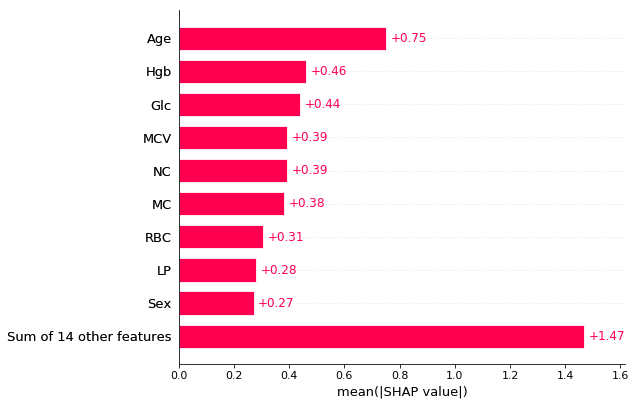

In [7]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_mod.get_booster())
shap_values = explainer(X)
shap.plots.bar(shap_values)

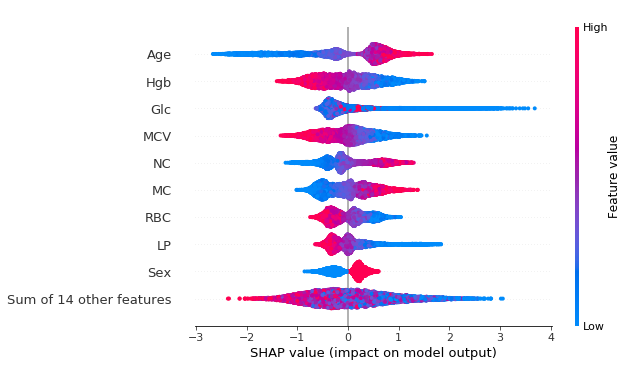

In [8]:

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

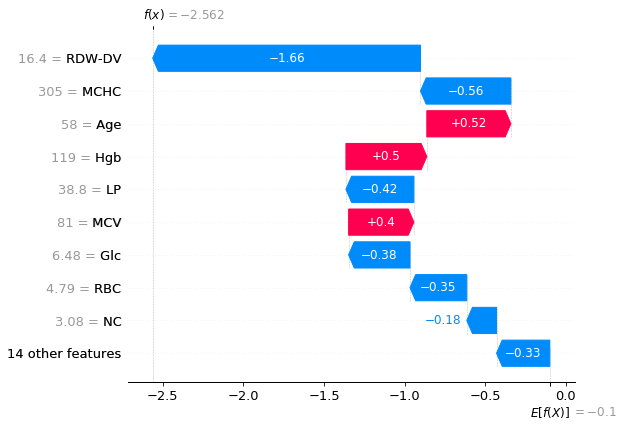

In [9]:
from matplotlib import cm
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[6000])

In [10]:
shap.plots.force(shap_values[6000],plot_cmap="PkYg")

In [ ]:
"""Red arrows represent feature effects (SHAP values) that drive the prediction value higher while blue arrows 
are those effects that drive the prediction value lower. Each arrow’s size represents 
the magnitude of the corresponding feature’s effect. The “base value” (see the grey print towards the upper-left of the
image) marks the model’s average prediction over the training set. The “output value” is the model’s prediction: 
probability 0.64. The feature values for the largest effects are printed at the bottom of the plot. 
Overall, the force plot provides an effective summary for this prediction."""

In [17]:
import sklearn as skl
predictions=xgb_mod.predict(X_test)
accuracy=skl.metrics.accuracy_score(y_test, predictions)
print(accuracy*100)

83.68320610687023


In [18]:
#  https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba  各种可视化figure的解释

In [25]:
#  Calculate SHAP values
"""
Compute SHAP values and SHAP interaction values for the first 20 test observations."""


expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_test.iloc[select]
features_display = X.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: -0.09985899180173874


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 20

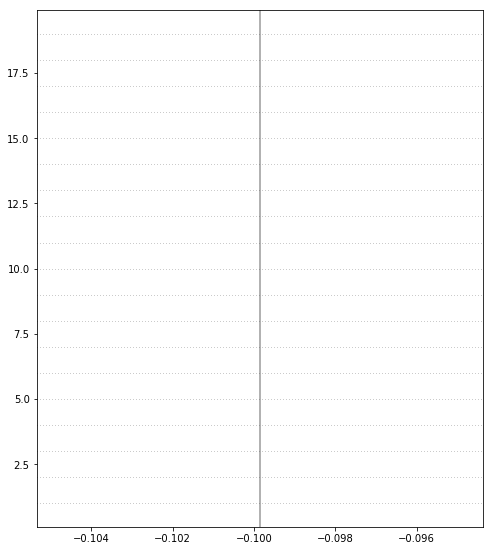

In [35]:
# Our naive cutoff point is zero log odds (probability 0.5).

# expected_value = explainer.expected_value
# y_pred = xgb_mod.predict(X_test)[select]
# misclassified = y_pred != y_test[select]
# shap.decision_plot(expected_value, shap_values, features_display, highlight=misclassified)

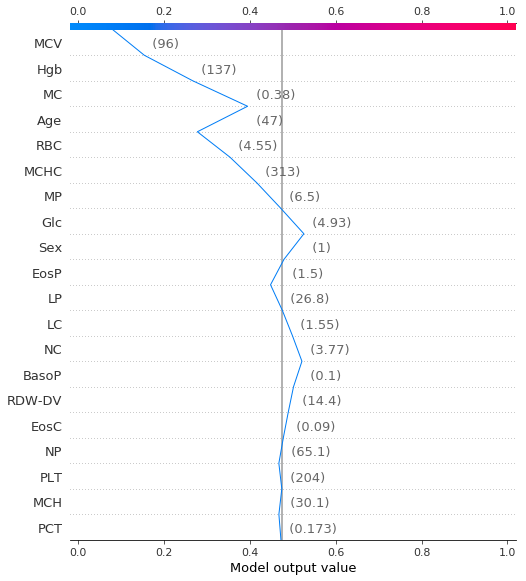

In [29]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

In [39]:
cols = ['Age','NC','LP','Hgb','MC','Glc','Sex','MCV','RDW-DV','RBC','NP','MCHC','MP','PCT','EosP']
row_index = 2
shap.multioutput_decision_plot(expected_value, shap_values,
                               row_index=row_index, 
                               feature_names=data[cols])    

NameError: name 'data' is not defined

In [46]:
# explainer2 = shap.Explainer(xgb_mod.predict_proba, X_train)
# shap_values2 = explainer2.shap_values(X_test)
# shap.force_plot(shap_values2[0])

In [48]:
explainer2 = shap.Explainer(xgb_mod)
shap_values2 = explainer2(X_test)

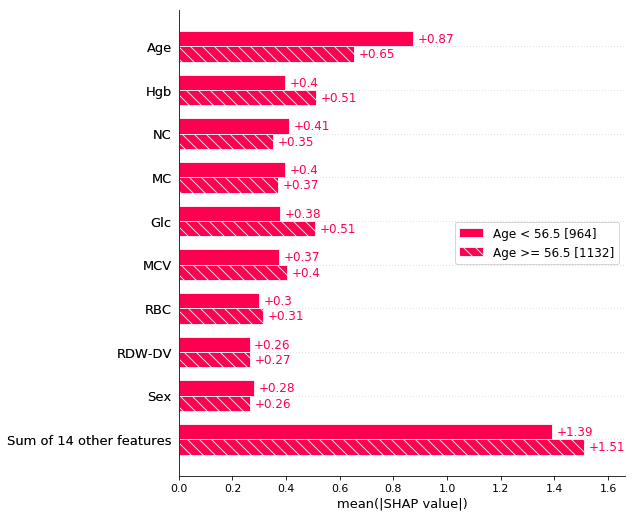

In [51]:
shap.plots.bar(shap_values2.cohorts(2).abs.mean(0))

In [ ]:
# # explain all the predictions in the test set
# explainer3 = shap.KernelExplainer(xgb_mod.predict_proba, X_train)
# shap_values3 = explainer3.shap_values(X_test)
# shap.force_plot(explainer3.expected_value[0], shap_values3[0], X_test)